# Batch Generating RM spectrum

Here we import all the things

In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../Optimus-Primal')

import faradaydreams.qu_fitting as qu_fitting
import numpy as np
import matplotlib.pyplot as plt
from dynesty import plotting as dyplot
import dynesty
from dynesty import utils as dyfunc

Here we choose observaitonal parameters (we have assumed something like CHIME)

In [2]:
c = 2.92 * 10**8
m_size = 1024 # number of samples in the signal
freq0 =  np.linspace(400, 800, m_size) * 10**6 #frequency coverage
#estimate lambda and frequency channel widths
dfreq = np.abs(freq0[1] - freq0[0]) 
lambda2 = (c/freq0)**2
lambda1 = np.sqrt(lambda2)

Here we define one and two component models

In [3]:
#model for a single component
def one_component(lambda2, P, rm, chi0):
    return P * np.cos(2 * rm * lambda2 + 2 * chi0) + 1j * P * np.sin(2 * rm * lambda2 + 2 * chi0)
#ideal model of two components
def two_component(lambda2, P1, rm1, chi1, P2, rm2, chi2):
    return one_component(lambda2, P1, rm1, chi1) + one_component(lambda2, P2, rm2, chi2) 

Here we define the parameters and the range of values we expect the parameters to be

In [4]:
two_comp_true_params = (3, 20, np.pi/2., 6, -50, 0 * np.pi)
one_comp_true_params = (3, 20, np.pi/2.)
def one_comp_prior_transform(utheta):
    P1, rm1, chi1 = utheta
    return 10 * P1, 50 * (2 * rm1 - 1), np.pi * chi1
def two_comp_prior_transform(utheta):
    P1, rm1, chi1, P2, rm2, chi2 = utheta
    return 10 * P1, 50 * (2 * rm1 - 1), np.pi * chi1, 10 * P2, 100 * (2 * rm2 - 1), np.pi * chi2

one_comp_labels = [r'$P$', r'$RM$', r'$\chi_0$']
two_comp_labels = [r'$P_1$', r'$RM_1$', r'$\chi_1$', r'$P_2$', r'$RM_2$', r'$\chi_2$']

Here we choose one or two components for our run

In [5]:
model_choice =  one_component
true_params = one_comp_true_params
prior_transform = one_comp_prior_transform
labels = one_comp_labels

We now choose how many samples/realizations and the input signal to noise level for each realization

In [6]:
realizations = 5 #number of realizations
ISNR = 10. #input noise level

Here we generate the measurements with noise assuming no averaging

In [7]:
y0 = model_choice(lambda2, *true_params)
sigma = 10**(-ISNR/20.)  * np.linalg.norm(y0) * 1./ np.sqrt(m_size * 2)
y = y0[np.newaxis,:] + np.random.normal(0, sigma, (realizations, m_size)) + 1j * np.random.normal(0, sigma, (realizations, m_size))

Text(0, 0.5, 'Realization')

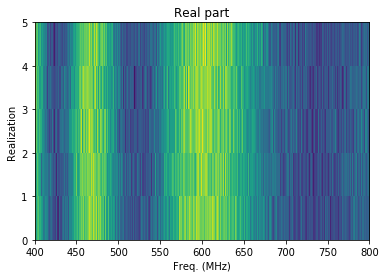

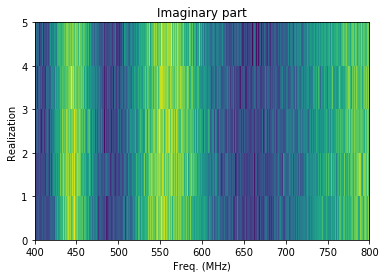

In [8]:
plt.figure()
plt.title("Real part")
plt.imshow(np.real(y),aspect="auto", extent=[freq0[0]/1e6, freq0[-1]/1e6, 0, realizations])
plt.xlabel("Freq. (MHz)")
plt.ylabel("Realization")
plt.figure()
plt.title("Imaginary part")
plt.imshow(np.imag(y),aspect="auto", extent=[freq0[0]/1e6, freq0[-1]/1e6, 0, realizations])
plt.xlabel("Freq. (MHz)")
plt.ylabel("Realization")

In [9]:
results = []
for realization in range(realizations):
    nlive = 1500
    dlogz_convergence = 0.05
    likelihood = lambda theta : qu_fitting.loglike(theta, model_choice, lambda2, y[realization, :], sigma)
    sampler = dynesty.NestedSampler(likelihood, prior_transform, len(true_params), nlive, bound='multi')
    sampler.run_nested(dlogz=dlogz_convergence)
    results.append(sampler.results)  # grab our results

31791it [00:18, 1689.25it/s, +1500 | bound: 26 | nc: 1 | ncall: 111566 | eff(%): 29.840 | loglstar:   -inf < -1072.037 <    inf | logz: -1090.207 +/-  0.150 | dlogz:  0.000 >  0.050]
31827it [00:18, 1745.90it/s, +1500 | bound: 26 | nc: 1 | ncall: 111565 | eff(%): 29.872 | loglstar:   -inf < -1025.774 <    inf | logz: -1043.968 +/-  0.150 | dlogz:  0.000 >  0.050]
31864it [00:19, 1623.68it/s, +1500 | bound: 26 | nc: 1 | ncall: 111797 | eff(%): 29.843 | loglstar:   -inf < -1063.631 <    inf | logz: -1081.850 +/-  0.150 | dlogz:  0.000 >  0.050]
31850it [00:18, 1765.60it/s, +1500 | bound: 26 | nc: 1 | ncall: 110136 | eff(%): 30.281 | loglstar:   -inf < -1004.967 <    inf | logz: -1023.177 +/-  0.150 | dlogz:  0.000 >  0.050]
32146it [00:20, 1596.92it/s, +1500 | bound: 26 | nc: 1 | ncall: 111115 | eff(%): 30.280 | loglstar:   -inf < -952.274 <    inf | logz: -970.681 +/-  0.151 | dlogz:  0.000 >  0.050]


RM realization:  1


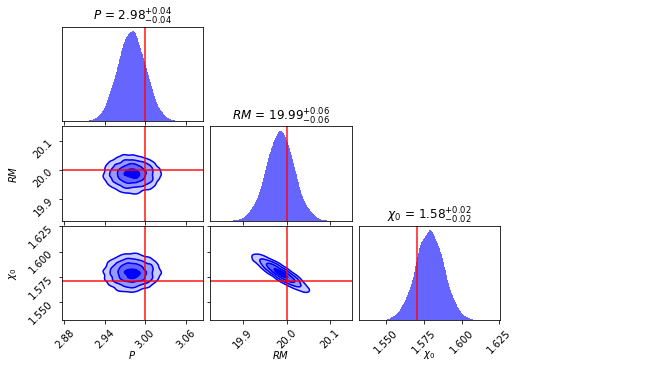

Mean values:
[ 2.98017308 19.9856905   1.57899525]
Covariance matrix values:
[[ 4.27706336e-04 -9.05188404e-06  3.05215277e-06]
 [-9.05188404e-06  1.02367993e-03 -2.75513237e-04]
 [ 3.05215277e-06 -2.75513237e-04  8.61964108e-05]]


In [10]:
fig, axes = plt.subplots(len(true_params), len(true_params)+1, figsize=(10, 5))
axes = axes.reshape((len(true_params), len(true_params)+1))
[a.set_frame_on(False) for a in axes[:, len(true_params)]]
[a.set_xticks([]) for a in axes[:, len(true_params)]]
[a.set_yticks([]) for a in axes[:, len(true_params)]]

realization = 1

print("RM realization: ", realization)
res = results[realization]
truths = np.array(true_params)
# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue', truth_color='red',
                           show_titles=True, max_n_ticks=4,
                           quantiles=None, fig=(fig, axes[:, :len(true_params)]), truths=truths, labels=labels)
plt.show()


# Extract sampling results.
samples = res.samples  # samples
weights = np.exp(res.logwt - res.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print("Mean values:")
print(mean)
print("Covariance matrix values:")
print(cov)